In [1]:
#Download dependencies 

import tensorflow as tf 
import os 
import cv2
import imghdr
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
from keras.regularizers import l1
from keras.regularizers import l2
from keras.layers.core import Activation, Dense
from keras.optimizers import Adam
from keras.optimizers import SGD
from keras.optimizers import Adagrad
from tensorflow.keras.optimizers.schedules import PolynomialDecay
from scipy.stats import gaussian_kde
import time

import keras.backend as K

In [2]:
# Avoid OOM errors by setting GPU Memory Comsumption Growth 
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
    
tf.config.list_physical_devices('GPU')

[]

In [3]:
direct_p = ('/Users/abelcouto/Documents/Dissertation/sample/Gray_Images')

print(os.listdir(direct_p))

['.DS_Store', 'Findings', 'No_Findings']


In [4]:
#Get data from directory, pipeline

data_pipe = tf.keras.utils.image_dataset_from_directory('Gray_Images', image_size=(600, 600),color_mode="grayscale", batch_size=65,class_names = ['Findings', 'No_Findings'])

Found 5606 files belonging to 2 classes.


In [5]:

data_iterator = data_pipe.as_numpy_iterator()

print (data_iterator)

In [6]:
#get information of batch, such as number of images, pixels and colour value

batch = data_iterator.next()

print((batch[0].shape))

2023-04-01 19:49:17.213396: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


(65, 600, 600, 1)


In [7]:
#Get image labels
print(batch[1])

[1 0 0 0 0 1 0 0 0 0 0 0 1 0 1 1 1 1 0 0 1 0 0 0 0 0 0 0 1 0 1 1 1 1 1 0 0
 1 1 0 0 0 0 1 1 1 0 1 0 0 0 1 0 0 1 1 1 0 1 1 1 1 0 0 1]


In [8]:
#Standardise the data so that it ranges from 0 to 1

data_pipe = data_pipe.map(lambda x,y: (x/255, y))

In [9]:
scaled_iterator = data_pipe.as_numpy_iterator()

In [10]:
batch= scaled_iterator.next()
print(batch[0].max())

1.0


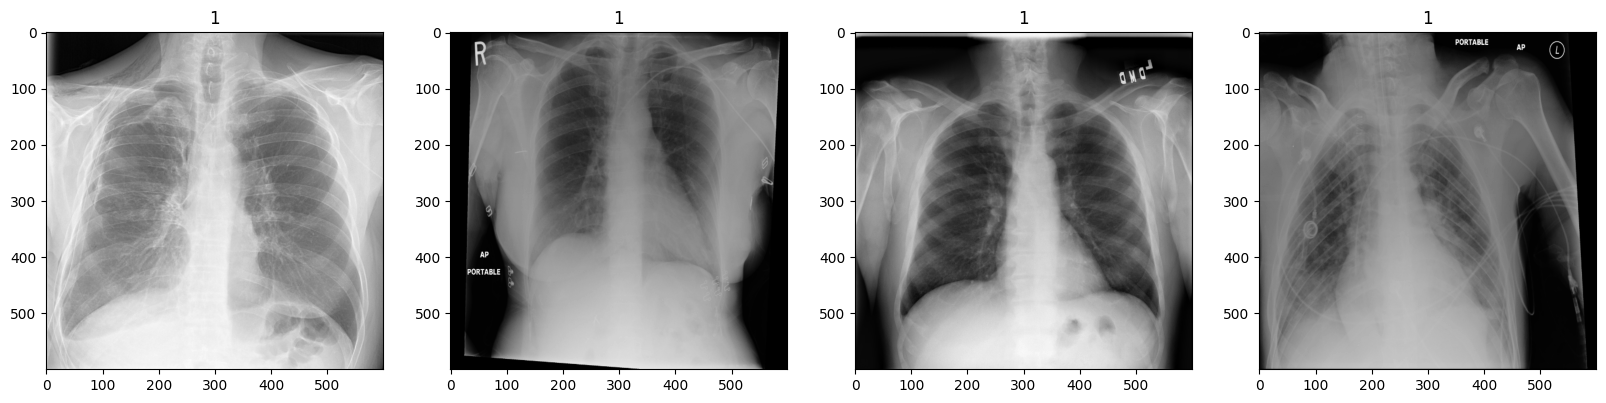

In [11]:

fig, ax = plt.subplots(ncols=4, figsize = (20,20))
for idx, img in enumerate(batch[0][:4]):
    
    ax[idx].imshow(img,cmap='gray')
    ax[idx].title.set_text(batch[1][idx])



In [12]:
print(len(data_pipe))

87


In [13]:
# Set parameters to divide our data sample
train_s = int(len(data_pipe)*.7)
val_s = int(len(data_pipe)*.2)+1
test_s = int(len(data_pipe)*.1)+1

In [14]:
print(test_s+train_s+val_s)

87


In [15]:
#Get data for train, val, test

train = data_pipe.take(train_s)
val = data_pipe.skip(train_s).take(val_s)
test = data_pipe.skip(train_s + val_s).take(test_s)

In [16]:
# Create Model 

model = Sequential()

In [17]:
model.add(Conv2D(8, (3,3),(2, 2), activation='relu', input_shape=(600,600,1)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
 
model.add(Conv2D(16, (3,3), (2, 2), activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(8, (3,3), (2, 2), activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))


model.add(Flatten())

model.add(Dense(2, activation ='linear', activity_regularizer=l1(0.001))) 
model.add(Activation('relu'))
model.add(Dense(1,activation='sigmoid')) 

In [18]:
#Polynominal Decay for SGD, which was not used with Adam 

num_epochs = 25
num_train_steps = train_s * num_epochs
lr_scheduler = PolynomialDecay(
    initial_learning_rate=0.01,
    end_learning_rate=0.00001,
    decay_steps=num_train_steps
)



opt = tf.keras.optimizers.Adam()
model.compile(optimizer = opt,loss= tf.losses.BinaryCrossentropy(),metrics= ['accuracy',tf.keras.metrics.Precision(),
                                                                     tf.keras.metrics.Recall()
                                                                     ])

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 299, 299, 8)       80        
                                                                 
 batch_normalization (BatchN  (None, 299, 299, 8)      32        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 149, 149, 8)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 149, 149, 8)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 74, 74, 16)        1168      
                                                                 
 batch_normalization_1 (Batc  (None, 74, 74, 16)       6

In [20]:
logdir = 'logs'

In [21]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = logdir)

In [22]:
#Train model and get time 

start = time.time()
hist = model.fit(train, epochs = 50, validation_data=val, callbacks = [tensorboard_callback])
stop = time.time()
print(f"Training time: {stop - start}s")

Epoch 1/50
60/60 [==============================] - 38s 607ms/step - loss: 0.8480 - accuracy: 0.4923 - precision: 0.5398 - recall: 0.4979 - val_loss: 0.7754 - val_accuracy: 0.5274 - val_precision: 0.5274 - val_recall: 1.0000
Epoch 2/50
60/60 [==============================] - 34s 550ms/step - loss: 0.7038 - accuracy: 0.5505 - precision: 0.5501 - recall: 0.9831 - val_loss: 0.9107 - val_accuracy: 0.5120 - val_precision: 0.5120 - val_recall: 1.0000
Epoch 3/50
60/60 [==============================] - 34s 553ms/step - loss: 0.7016 - accuracy: 0.5503 - precision: 0.5518 - recall: 0.9819 - val_loss: 0.8851 - val_accuracy: 0.5427 - val_precision: 0.5427 - val_recall: 1.0000
Epoch 4/50
60/60 [==============================] - 34s 555ms/step - loss: 0.7016 - accuracy: 0.5477 - precision: 0.5485 - recall: 0.9864 - val_loss: 1.0446 - val_accuracy: 0.5308 - val_precision: 0.5308 - val_recall: 1.0000
Epoch 5/50
60/60 [==============================] - 34s 559ms/step - loss: 0.6999 - accuracy: 0.5482

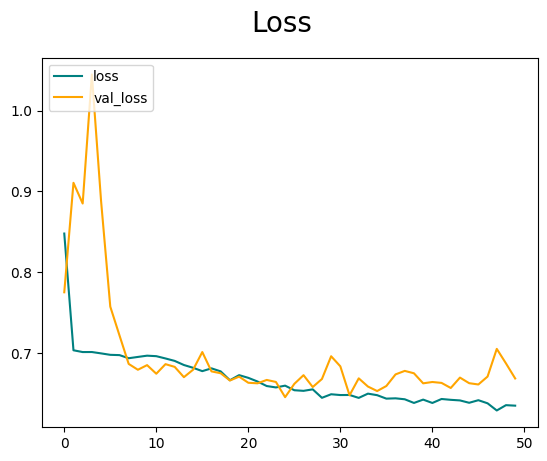

In [23]:
#plot loss

fig = plt.figure()
plt.plot(hist.history['loss'], color= 'teal', label = 'loss')
plt.plot(hist.history['val_loss'], color= 'orange', label = 'val_loss')
fig.suptitle('Loss', fontsize = 20)
plt.legend(loc= 'upper left')
plt.show()

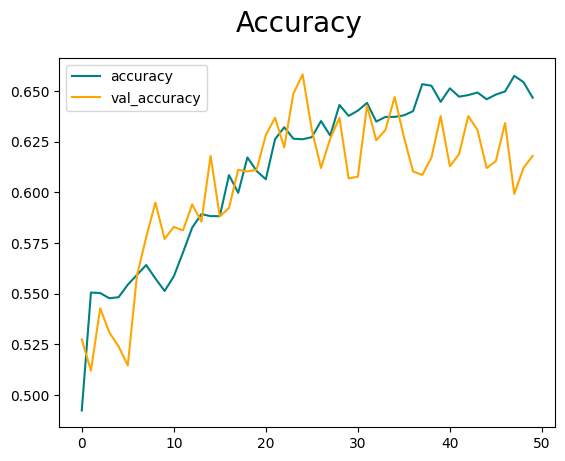

In [24]:
#plot accuracy

fig = plt.figure()
plt.plot(hist.history['accuracy'], color= 'teal', label = 'accuracy')
plt.plot(hist.history['val_accuracy'], color= 'orange', label = 'val_accuracy')
fig.suptitle('Accuracy', fontsize = 20)
plt.legend(loc= 'upper left')
plt.show()

In [25]:
hist.history

{'loss': [0.848008930683136,
  0.7037656903266907,
  0.7015562057495117,
  0.7016001343727112,
  0.6999219655990601,
  0.6981335878372192,
  0.6977868676185608,
  0.6939316987991333,
  0.6955376267433167,
  0.6970945596694946,
  0.6964789032936096,
  0.6936428546905518,
  0.6906301975250244,
  0.6855570673942566,
  0.6821221709251404,
  0.6779785752296448,
  0.681418240070343,
  0.6776655316352844,
  0.6667255163192749,
  0.6730362176895142,
  0.6696908473968506,
  0.6651701927185059,
  0.6595742106437683,
  0.6578478217124939,
  0.6600545048713684,
  0.6543822884559631,
  0.6536365151405334,
  0.6554926633834839,
  0.6450254917144775,
  0.6494067907333374,
  0.6484373211860657,
  0.6485199928283691,
  0.6449215412139893,
  0.6501762866973877,
  0.6482757329940796,
  0.6440069079399109,
  0.6443902254104614,
  0.6432088017463684,
  0.638683557510376,
  0.6428021788597107,
  0.6386502981185913,
  0.6435685157775879,
  0.6425352096557617,
  0.641796886920929,
  0.6388774514198303,
  0.64

In [26]:
prec = Precision()
rec = Recall()
acc = BinaryAccuracy()

In [27]:
for batch in test.as_numpy_iterator():
    x,y = batch
    yhat = model.predict(x)
    prec.update_state(y, yhat)
    rec.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 35ms/step


In [28]:
print(f'Precision: {prec.result().numpy()}, Recall: {rec.result().numpy()}, Accuracy: {acc.result().numpy()}')


Precision: 0.6523178815841675, Recall: 0.6936619877815247, Accuracy: 0.641791045665741


In [29]:
F05 = (1.25 * prec.result().numpy() * rec.result().numpy()) / (0.25 * prec.result().numpy()+ rec.result().numpy())

In [30]:
print(F05)

0.6601876710968694


In [31]:
print(tf.__version__)

2.10.0
